# Hidden Markov Model Demo

A Hidden Markov Model (HMM) is one of the simpler graphical models available in _SSM_. This notebook demonstrates creating and sampling from and HMM using SSM, and fitting an HMM to synthetic data. A full treatment of HMMs is beyond the scope of this notebook, but there are many good resources. [Stanford's CS228 Lecture Notes](https://ermongroup.github.io/cs228-notes/) provide a good introduction to HMMs and other graphical models. [Pattern Recognition and Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) by Christopher Bishop covers HMMs and how the EM algorithm is used to fit them from data.
  
  
The goal of these notebooks is to introduce state-space models to practitioners who have some familiarity with them, but who may not have used these models in practice before. As such, we've included a few exercises to try as you make your way through the notebooks.

## 1. Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)
import sys

sys.path.append('/home/jupyter/ssm')

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

## 2. Create an HMM
An HMM consists of a set of hidden state variable, $z$, which can take on one of $K$ values (for our purposes, HMMs will always have discrete states), along with a set of transition probabilities for how the hidden state evolves over time. 
In other words, we have $z_t \in \{1, \ldots, K\}$, where $z_t = k$ denotes that the hidden variable is in state $k$ at time $t$.


The key assumption in an HMM is that only the most recent state affects the next state. In mathematical terms:

$$
p(z_t \mid z_{t-1}, z_{t-2}, \ldots, z_1) = p(z_t \mid z_{t-1})
$$

In an HMM, we don't observe the state itself. Instead, we get a noisy observation of the state at each time step according to some observation model. We'll use $x_t$ to denote the observation at time step $t$. The observation can be a vector or scalar. We'll use $D$ to refer to the dimensionality of the observation. A few of the supported observation models are:

1. **Gaussian**: Each discrete state $z_t = k$ is associated with a $D$-dimensional mean $\mu_k$ and covariance matrix $\Sigma_k$. Each observation $z_t$ comes from a Gaussian distribution centered at the associated mean, with the corresponding covariance.

2. **Student's T**: Same as Gaussian, but the observations come from a Student's-T Distribution.

3. **Bernoulli**: Each element of the $D$-dimensional observation is a Bernoulli (binary) random variable. Each discrete state $Z_i$ determines the probability that each element in the observation is nonzero.

_Note: SSM supports many other observation models for HMMs. We are in the process of creating full-standalone documentation to describe them. For now, the best way to learn about SSM's other functionality is look at the source code. The observation models are described in observations.py._


In the below example, we create an instance of the HMM with 5 discrete states and 2 dimensional observations. We store our HMM instance in a variable called true_hmm with this line:

`
true_hmm = ssm.HMM(K, D, observations="gaussian")
`

We then manually set the means for each latent state to make them farther away (this makes them easier to visualize).

`
true_hmm.observations.mus = 3 * np.column_stack((np.cos(thetas), np.sin(thetas)))
`

Here we are modifying the `observations` instance associated with the HMM we created above. We could also change the covariance, but for now we're leaving it with the default (identity covariance).

In [3]:
# Set the parameters of the HMM
time_bins = 200   # number of time bins
num_states = 5    # number of discrete states
obs_dim = 2       # dimensionality of observation

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

# Manually tweak the means to make them farther apart
thetas = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
true_hmm.observations.mus = 3 * np.column_stack((np.cos(thetas), np.sin(thetas)))

## 3. Sample from the HMM

We draw samples from an HMM using the `sample` method:  
`true_states, obs = true_hmm.sample(time_bins)`.  

This returns a tuple $(z, x)$ of the latent states and observations, respectively.
In this case, `true_states` will be an array of size $(200,)$ because it contains the discrete state $z_t$ across $200$ time-bins. `obs` will be an array of size $(200, 2)$ because it contains the observations across $200$ time bins, and each observation is two dimensional.
We have specified the number of time-steps by passing `time_bins` as the argument to the `sample` method.

In the next line, we retrieve the log-likelihood of the data we observed:  
`true_ll = true_hmm.log_probability(obs)`  

This tells us the relative probability of our observations. In the next section, when we fit an HMM to the data we generated, the true log-likelihood will be helpful for determining if our fitting algorithm succeeded.

In [4]:
# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

In [5]:
# Plot the observation distributions
lim = .85 * abs(obs).max()
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = true_hmm.observations.log_likelihoods(data, input, mask, tag)

Below, we plot the samples obtained from the HMM, color-coded according to the underlying state. The solid curves show regions of of equal probability density around each mean. The thin gray lines trace the latent variable as it transitions from one state to another.

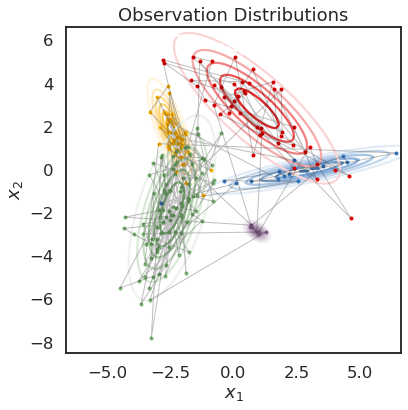

In [6]:
plt.figure(figsize=(6, 6))
for k in range(num_states):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(obs[true_states==k, 0], obs[true_states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(obs[:,0], obs[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

if save_figures:
    plt.savefig("hmm_1.pdf")

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the "true" values of the observation variable (the mean) while the solid lines are the actual observations sampled from the HMM.

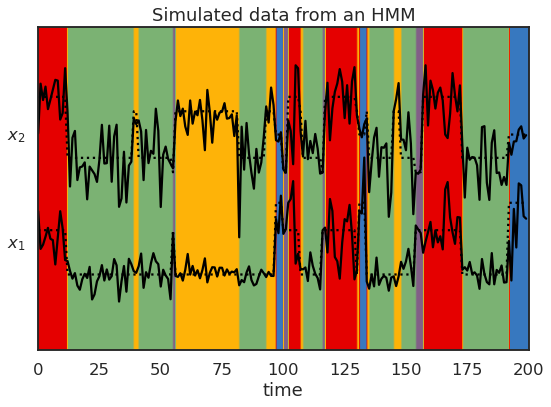

In [7]:
# Plot the data and the smoothed data
lim = 1.05 * abs(obs).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None,:],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))

Ey = true_hmm.observations.mus[true_states]
for d in range(obs_dim):
    plt.plot(obs[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

plt.title("Simulated data from an HMM")

plt.tight_layout()

if save_figures:
    plt.savefig("hmm_2.pdf")

### Exercise 3.1: Change the observation model
Try changing the observation model to Bernoulli and visualizing the sampled data. You'll need to create a new HMM object with Bernoulli observations. Then, use the `sample` method to sample from it. Visualizing the mean vectors and contours makes sense for Gaussian observations, but might not be the best way to visualize Bernoulli observations. 

In [7]:
# Your code here: create an HMM with Bernoulli observations
# ---------------------------------------------------------


# 4. Fit an HMM to synthetic data
This is all fine, but so far we haven't done anything that useful. It's far more interesting to learn an HMM from data. In the following cells, we'll use the synthetic data we generated above to fit an HMM from scratch. This is done in the following lines:

`
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")
hmm_lls = hmm.fit(obs, method="em", num_em_iters=N_iters)
`

In the first line, we create a new HMM instance called `hmm` with a gaussian observation model, as in the previous case. Because we haven't specified anything, the transition probabilities and observation means will be randomly initialized. In the next line, we use the `fit` method to learn the transition probabilities and observation means from data. We set the method to `em` (expectation maximization) and specify the maximum number of iterations which will be used to fit the data. The `fit` method returns a numpy array which shows the log-likelihood of the data over time. We then plot this and see that the EM algorithm quickly converges.

  0%|          | 0/50 [00:00<?, ?it/s]

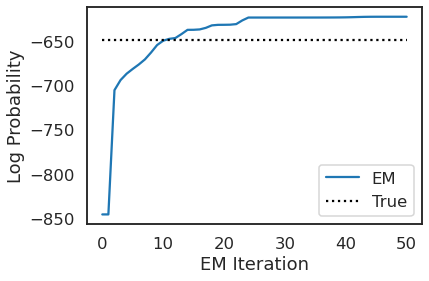

In [8]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 50

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

The below cell is a bit subtle. In the first section, we sampled from the HMM and stored the resulting latent state $z$ in a variable called `state`. 
Now, we are treating our observations from the previous section as data, and seeing whether we can infer the true state given only the observations. However, there is no guarantee that the states we learn correspond to the original states from the true HMM. In order to account for this, we need to find a permutation of the states of our new HMM so that they align with the states of the true HMM from the prior section. This is done in the following two lines:

`most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))
`  
  
In the first line, we use the `most_likely_states` method to infer the most likely latent states given the observations.  In the second line we call the `find_permutation` function the permutation that best matches the true state. We then use the `permute` method on our `hmm` instance to permute its states accordingly.



In [9]:
# Find a permutation of the states that best matches the true and inferred states
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

Below, we plot the inferred states ($z_{\mathrm{inferred}}$) and the true states ($z_{\mathrm{true}}$) over time. We see that the two match very closely, but not exactly. The model sometimes has difficulty inferring the state if we only observe that state for a very short time.

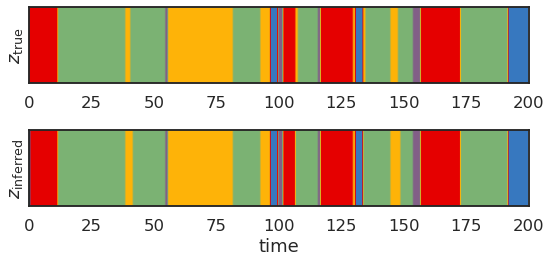

In [10]:
# Plot the true and inferred discrete states
hmm_z = hmm.most_likely_states(data)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

An HMM can also be used to smooth data (once its parameters are learned) but computing the mean observation under the posterior distribution of latent states. 
Let's say, for example, that during time steps 0 to 10 the model estimates a 0.3 probability of being in state 1, and a 0.7 probability of being in state 2, given the observations $x$.
Mathematically, that's saying we've computed the following probabilities:  
$$
p(z=1 \mid X) = 0.3\\
p(z=3 \mid X) = 0.7
$$
  
The smoothed observations would then be $0.3 \mu_1 + 0.7 \mu_2$, where we $\mu_i$ is the mean for the observations in state $i$.
In the cell below, we use `hmm.smooth(obs)` to smooth the data this way. The orange and blue lines show the smoothed data, and the black lines show the original noisy observations.

Text(0.5, 0, 'time')

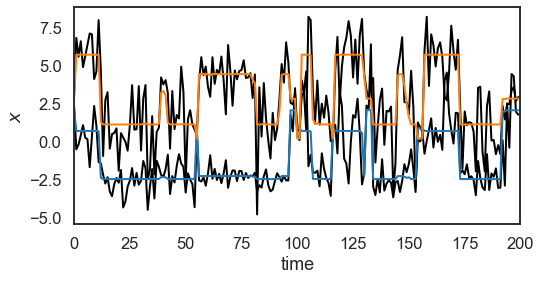

In [17]:
# Use the HMM to "smooth" the data
hmm_x = hmm.smooth(obs)

plt.figure(figsize=(8, 4))
plt.plot(obs + 3 * np.arange(obs_dim), '-k', lw=2)
plt.plot(hmm_x + 3 * np.arange(obs_dim), '-', lw=2)
plt.xlim(0, time_bins)
plt.ylabel("$x$")
# plt.yticks([])
plt.xlabel("time")

### 4.1. Visualize the Transition Matrices
The dynamics of the hidden state in an HMM are specified by the transition probabilities $p(z_t \mid z_{t-1})$. It's standard to pack these probabilities into a stochastic matrix $A$ where $A_{ij} = p(z_t = j \mid z_{t-1} = i)$.

In SSM, we can access the transition matrices using `hmm.transitions.transition` matrix. In the following two lines, we retrives the transition matrices for the true HMM, as well as the HMM we learned from the data, and compare them visually.

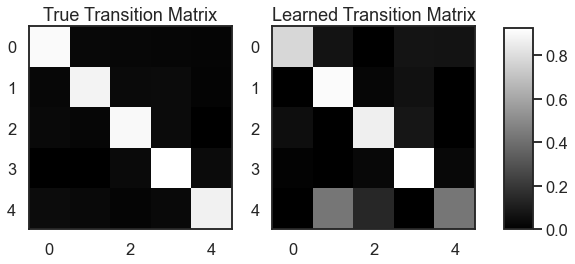

In [18]:
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


### Excercise 4.2: Distribution of State Durations
Derive the theoretical distribution over state durations. Do the state durations we observe ($Z_{true}$ in section 4) match the theory? If you're stuck, imagine that the system starts in state $1$, i.e $z_1 = 1$. What's the probability that $z_2 = 1$? From here, you might be able to work forwards in time.

When done, check if your derivation matches what we find in the section below.

### 4.3: Visualize State Durations


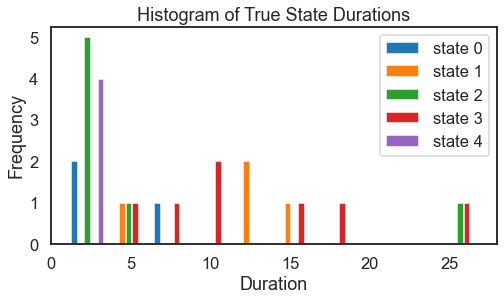

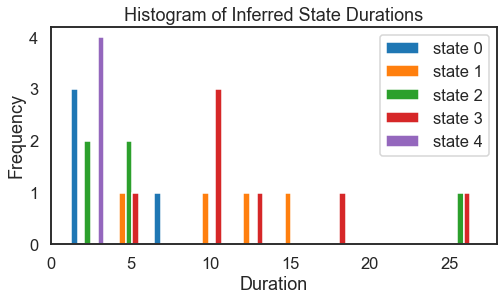

In [19]:
true_state_list, true_durations = ssm.util.rle(true_states)
inferred_state_list, inferred_durations = ssm.util.rle(hmm_z)

# Rearrange the lists of durations to be a nested list where
# the nth inner list is a list of durations for state n
true_durs_stacked = []
inf_durs_stacked = []
for s in range(num_states):
    true_durs_stacked.append(true_durations[true_state_list == s])
    inf_durs_stacked.append(inferred_durations[inferred_state_list == s])
    
fig = plt.figure(figsize=(8, 4))
plt.hist(true_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of True State Durations')

fig = plt.figure(figsize=(8, 4))
plt.hist(inf_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Inferred State Durations')

plt.show()

### Excercise 4.4: Fit an HMM using more data
We see that the above histograms do not match each other as closely as we might expect. They also don't match the theoretical distriubtion of durations all that closely (see Exercise 4.2). Part of the reason for this is that we have sampled from a relatively small number of time steps.   

Try modifying the `time_bins` variable to sample for more time-steps (say 2000 or so).
Then, re-run the analysis above. Because of the larger time frame, some of the plots above may become hard to read, but the histogram of durations should more closely match what we expect.

### Exercise 4.5: Mismatched Observations
Imagine a scenario where the true data comes from an HMM with Student's T observations, but you fit an HMM with Gaussian observations. What might you expect to happen?  

You can try simulating this: modify the code in Section 2 so that we create and HMM with Student's T observations. Then re-run the cells in Section 4, which will fit an HMM with Gaussian observations to the observed data. What do you see?